In [373]:
import pandas as pd
import numpy as np
import collections
import re

# spacy code below: 
# import spacy
# nlp = spacy.load("en_core_web_sm")

data = pd.read_csv("Labelled_VR_data_Oct2020_Jan2021_wfulltext.csv")

# Common Opinion and News Terms (Additional Features)

In [374]:
#possible opinion terms

opinion = ["opinion", 
           "analysis",  
           "guest columnist", 
           "letter to the editor", 
           "letters to the editor",
           "editorial", 
           "editor",
           "column",
           "editorial board",
           "editors", 
           "readers", 
           "columnist", 
           "special", 
           "you", 
          ]

#possible news terms

news = ["editor", 
        "staff writer",
        "staff writers",
        "bureau", 
        "news",
        "news service", 
        "contributing writer",   
        "news group",
        "bureau chief",
        "contributed", 
        "compiled by", 
        "staff",
        "editor in chief", 
        "editor-in-chief", 
        "managing editor", 
        "political editor", 
        "editor-at-large", 
        "correspondent", 
        "yesterday", 
        "last", 
        "say"
        "some", 
        "company", 
        "official", 
        "plan",
        "here",
        "mr",
        "associated press", 
        "reuters", 
        "report"
       ]


# Linguistic Features

In [375]:
#linguistic features —  SENTLENGTH and TOKENLENGTH
#hypothesis being that opinion texts, such as editorials, tend to feature longer sentences 
#art_str is the article as a String

def sent_len(art_str):
    """
    Returns the average sentence length measured in tokens (inverted).
    """
    dots = [p for p in range(len(art_str)) if art_str[p] == "."]
    sentences = [dots[i+1] - dots[i] for i in range(len(dots) - 1)]
    return (1/np.average(sentences)) if sentences else (1/len(art_str))
    
def token_len(art_str):
    """
    Returns the average token length measured in characters (inverted).
    """
    wordList = art_str.split()
    lengths = [len(w) for w in wordList]
    return 1/(np.average(lengths)), np.sum(lengths)


In [376]:
#linguistic features — NEGATION and NEGATIONSUFFIX 
#NEGATION — OPINION
#NEGATIONSUFFIX — NEWS
#hypothesis being that opinion texts tend to have more negations 
#n't is used commonly in citations or quotes

negations = ["no", "not", "none", "no one", "nobody", "neither", "nowhere", "nothing", "never"]
neg_suffix = "n\'t"


In [377]:
def negations_count(art_str):
    wordList = art_str.lower().split()
    total, suffix_total = 0, 0
    for w in wordList:
        if w in negations:
            total += 1
        if w[-3:] == neg_suffix:
            suffix_total += 1
    return total, suffix_total
    

In [378]:
#linguistic features — QUESTIONS, EXCLAMATIONS, COMMAS, and SEMICOLONS
#hypothesis being that opinion texts tend to use more exclamations and (rhetorical) questions
#exclamation marks, question marks, semicolons, and commas
#QUESTIONS, EXCLAMATIONS, COMMAS, SEMICOLONS — OPINION
#COMMAS — NEWS
 
def punctuation_count(art_str):
    """
    Determines the numbers of exclamation marks, question marks, semicolons, and commas,
    as compared to other punctuation symbols. 
    """
    count = [0] * 5
    for i in range(len(art_str)):
        if art_str[i] == "?":
            count[0] += 1
        elif art_str[i] == "!":
            count[1] += 1
        elif art_str[i] == ",":
            count[2] += 1
        elif art_str[i] == ";":
            count[3] += 1
        elif art_str[i] == ".":
            count[4] += 1
    return count


In [379]:
#linguistic features — CONNECTIVES (Temporal, Casual, Contrastive, Expansive)
#hypothesis being that there are more connectives in news (aftermath of study)
#casual, expansive, temporal, contrastive — NEWS 


causal = ['after', 'because', 'insofar as', 'by', 'in turn', 'for', 'once', 'as a result', 'hence', 'in the end', 
          'by then', 'but', 'subsequently', 'as', 'therefore', 'unless', 'thus', 'accordingly', 'so that', 'since', 
          'consequently', 'indeed', 'ultimately', 'then', 'even though', 'now that', 'finally”,”hence”,”if', 'although', 
          'so', 'thereby', 'otherwise', 'due to', 'and', 'when']

contrastive = ['nor', 'in fact', 'despite', 'equally', 'by comparison', 'contrast', 'by contrast', 'but', 'separately', 
               'whereas', 'rather', 'meanwhile', 'also', 'even so', 'and', 'though', 'if', 'unlike', 'however', 'or', 'then', 
               'nevertheless', 'yet', 'even though', 'conversely', 'nonetheless', 'on the contrary', 'in contrast', 'while', 
               'likewise', 'instead', 'although', 'on the other hand', 'still', 'similarly', 'otherwise', 'actually', 
               'alternatively', 'on the one hand', 'when']

temporal = ["before", "after", "next", "shortly", "afterwards", "eventually", "firstly", "secondly", "previously", "meanwhile",
            "finally", "while", "then", "earlier", "when", "initially", "soon", "suddenly", "until", "once", "recently", "already", "as"]

expansive = ["also", "and", "as well as", "besides", "in addition", "furthermore", "in fact", "moreover", "additionally",
             "too", "further", "or", "neither", "nor", "either"]


In [380]:
def connective_count(art_str):
    # casual, contrastive, temporal, expansive
    connectives = [0] * 4
    wordList = art_str.lower().split()
    for w in wordList:
        if w in casual:
            connectives[0] += 1
        elif w in contrastive:
            connectives[1] += 1
        elif w in temporal:
            connectives[2] += 1
        elif w in expansive:
            connectives[3] += 1
    return connectives


In [381]:
#linguistic features — PRONOUNS outside of quotes — OPINION
#study used first and second person only


first_person = ['I', 'we', 'our', 'ourselves', 'us', 'me', 'my', 'mine', 'myself']
second_person = ['you', 'yours', 'your', 'yourself', 'yourselves']
third_person = ['he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 
                'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']


In [382]:
def pronouns_count(art_str):
    wordList = art_str.lower().split()
    pronoun_count = [0] * 3
    for w in wordList:
        if w in first_person:
            pronoun_count[0] += 1
        elif w in second_person:
            pronoun_count[1] += 1
        elif w in third_person:
            pronoun_count[2] += 1
    return pronoun_count
    

In [383]:
#linguistic features — CITATIONS and CITATIONLENGTH — OPINION
#hypothesis being that higher frequencies of citations are more indicative of opinion (aftermath of study)

def find_citation(art_str):
    """
    Returns the citation length and frequency in the article. 
    """
    quotes = re.findall(r'"(.*?)"', art_str)
    within_quotes = collections.Counter(" ".join(quotes).lower().split())
    num_citations = len(quotes)
    avg_citation_len = np.average([len(q) for q in quotes])
    return [num_citations, avg_citation_len]


In [384]:
#linguistic features — MODALS — OPINION
#hypothesis being that modal verbs are expected to be a better indicator for opinion 
#according to study, is less potent but do correspond to the genre as expected

modals = ["can", "must", "may", "could", "might", "should", "would", "shall", "ought to"]


In [385]:
#linguistic features — VERBSofSAYING (VoS) — NEWS
#hypothesis that vos more common in news

vos = ['acknowledge','affirm','allege','announce','assert','claim','comment','contend','declare','disclose',
       'exclaim','explain','insist','mention','notify','observe','proclaim','propose','report','reveal','said','say','state',
       'stipulate','tell','write']


In [386]:
#linguistic features — FUTURE_WILL — NEWS
#frequency of the verb, "will" outside of quotes

future_will = "will"


In [387]:
#linguistic features — DIGITS — OPINION
#hypothesis being that digits are more frequent in opinion than news (aftermath of study)

def count_digits(art_str):
    """
    Returns the frequency of digits in a text. 
    """
    return len(re.findall("[\d]+",art_str))/len(art_str)


In [388]:
#complexity and finite verbs

def get_finite_verbs(art_str):
    finite_verb_tags = ["VBD", "VBP", "VBZ", "MD", "BES", "HVS"]
    return [w for w in nlp(art_str) if w.tag_ in finite_verb_tags]

def calc_complexity_(art_str):
    num_finite_verbs = len(get_finite_verbs(art_str))
    if num_finite_verbs == 0:
        return 0
    complexity = num_finite_verbs / token_len(art_str)[1]
    return complexity


In [389]:
#interjection frequency

def get_interjections(art_str):
    interjections = [w for w in nlp(art_str) if w.pos_ == "INTJ"]
    num_tokens = token_len(art_str)[1]
    if not interjections or not num_tokens:
        return 0
    intj_freq = len(interjections) / num_tokens
    return intj_freq


In [390]:
#finite verbs, complexity, and interjection frequency 

def get_finite_interjections(art_str):
    finite_verb_tags = ["VBD", "VBP", "VBZ", "MD", "BES", "HVS"]
    finite_verbs, num_intj = [], 0
    for w in nlp(art_str):
        if w.tag_ in finite_verb_tags:
            finite_verbs.append(w)
        if w.pos_ == "INTJ":
            num_intj += 1
    num_tokens = token_len(art_str)[1]
    return finite_verbs, len(finite_verbs)/num_tokens, num_intj / num_tokens


In [391]:
#present and past tense frequency

def get_tense_freq(finite_verbs):
    if not finite_verbs:
        return 0, 0
    past, present, num_finite = 0, 0, len(finite_verbs)
    for w in finite_verbs:
        if w.tag_ == "VBZ" or w.tag_ == "VBP":
            present += 1
        elif w.tag_ == "VBD":
            past += 1
    return (past / finite_verbs), (present / finite_verbs)

def present_tense_freq(finite_verbs):
    if not finite_verbs:
        return 0
    present_verbs = [w for w in finite_verbs if w.tag_ == "VBZ" or w.tag_ == "VBP"]
    present_tense_frequency = len(present_verbs) / len(finite_verbs)
    return present_tense_frequency

def past_tense_freq(finite_verbs):
    if not finite_verbs:
        return 0
    past_verbs = [w for w in finite_verbs if w.tag_ == "VBD"]
    past_tense_frequency = len(past_verbs) / len(finite_verbs)
    return past_tense_frequency


In [392]:
# Subjectivity Dictionary
import json
mpqa_dict = json.load(open("mpqa_dict.json", "r"))


In [393]:
#linguistic features — SENTIMENT — OPINION
#hypothesis being that opinion texts employ a less neutral language
#calculated in study using MPQA Subjectivity Clues Lexicon 

def get_sentiment(art_str, mpqa_dict):
    subjectivity, adjectives = 0, 0
    words = art_str.lower().split()
    
    for w in words:
        if w in mpqa_dict:  
            if mpqa_dict[w]['pos'] == 'adj':
                adjectives += 1
            if mpqa_dict[w]['subj'] == 'weaksubj':
                subjectivity += 0.1
            if mpqa_dict[w]['subj'] == 'strongsubj':
                subjectivity += 1
          
    num_words = len(words)
    sentiment = subjectivity / num_words
    adj_ratio = adjectives / num_words
    
    return subjectivity, sentiment, adjectives, adj_ratio


In [394]:
# David's Additional Features Code

#These Journalist Name terms are only found in opinion articles

df = data
name_only_opinion = ["opinion",
                    "letters? to the editor",
                    "letters\:",
                    "editorial board",
                    "readers", 
                    "columnist"]

#These Headline terms are only found in opinion articles
headline_only_opinion = ["letters? to the editor",
                        "letters\:", 
                        "columnist"]

#These Full Text terms are only found in opinion articles
fulltext_only_opinion = ["letters? to the editor"]


#These Journalist Name terms are only found in news articles
name_only_news = ["contributed",
            "bureau",  
            "compiled by"]

#These Full Text terms are only found in news articles
fulltext_only_news = ["\(ap\)",
                    "contributed to this report"]

#Format text fields for searching
df["fulltext_lower"] = df["Full Text"].fillna("").str.lower()
df["journo_name_lower"] = df["Journalist Name"].fillna("").str.lower()
df["headline_lower"] = df["Headline"].fillna("").str.lower()


#Create column for articles matching news-only regex patterns
#or associated press in name field where headline does not equal 'editorial roundup'
df["news_rule"] = np.where(((df["fulltext_lower"].str.contains("|".join(fulltext_only_news), regex=True))|
                           (df["journo_name_lower"].str.contains("|".join(name_only_news), regex=True))|
                           ((df["journo_name_lower"].str.contains("associated press")) & 
                            -(df["headline_lower"].str.contains("editorial roundup")))), 
                          "Present", "Not present")

#Create column for articles matching opinion-only regex patterns
df["opinion_rule"] = np.where(((df["fulltext_lower"].str.contains("|".join(fulltext_only_opinion), regex=True))|
                              (df["journo_name_lower"].str.contains("|".join(name_only_opinion), regex=True))|
                               (df["headline_lower"].str.contains("|".join(headline_only_opinion), regex=True))),
                              "Present", "Not present")

#Code to check results of rule-based classification
#df.groupby(["opinion_rule","news_rule","news_opinion"]).size()

#These terms appear more often in opinion articles
name_lean_opinion = ["editor"]

headline_lean_opinion = ["opinion", 
                          "editor",
                          "editorial",
                          "column"]

fulltext_lean_opinion = ["editorial board",
                         "columnist"]


#These terms appear more often in news articles
name_lean_news = ["staff writer",
            "staff", 
            "news"]

headline_lean_news = ["news"]

fulltext_lean_news = ["associated press",
            "reuters",
            "staff writer",
            "staff writers",
            "staff", 
            "bureau", 
            "contributed", 
            "compiled by", 
            "correspondent"]
def create_feature_from_terms(term_list, column, df=df):
    '''(List, series, df -> df) loop through (lower-case) list of terms, check for presence of that term in the specified column, 
    and create feature column where 1 denotes presence of the term'''
    
    for item in term_list:
        df[item + "_" + column + "_" + "feature"] = np.where(df[column].fillna("").str.lower().str.contains(item), 1, 0)
    
    return df
#Create dummy-coded (0/1) feature columns from terms lists
df = create_feature_from_terms(name_lean_opinion, "Media Name")
df = create_feature_from_terms(headline_lean_opinion, "Headline")
df = create_feature_from_terms(fulltext_lean_opinion, "Full Text")
df = create_feature_from_terms(name_lean_news, "Media Name")
df = create_feature_from_terms(headline_lean_news, "Headline")
df = create_feature_from_terms(fulltext_lean_news, "Full Text")
#Additional features

#Dateline feature
#News articles sometimes start with datelines, which are ALL CAPS
#This checks if the article starts with at least 3 all caps letters
df["upper_start_feature"] = np.where(df["Full Text"].str.contains('^[A-Z]{3,20} ', regex=True), 1, 0)

#MediaName feature
#The Hill, Associated Press and Reuters are all mainly news articles
df["media_lean_news_feature"] = np.where(df["Media Name"].fillna("").str.contains("Reuters|Associated Press|thehill|The Hill", regex=True), 1, 0)

#Headline length feature
#On average, news headlines are slightly longer than opinion headlines
#df.groupby(["news_opinion"])["headline_length"].mean()
df["headline_length_feature"] = df["Headline"].str.len()

#Author count feature
#News articles tend to have slightly more authors
#df.groupby(["news_opinion","author_count"]).size()
df["author_count_feature"] = df["Cleaned Author"].str.count(", ") + 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
a = df["Headline"].str.len()
b = df["Cleaned Author"].str.count(", ") + 1
zipped = list(zip(a,b))
fitted = scaler.fit(zipped)
arr = scaler.transform(zipped)
t = zip(*arr)
new = list(t)
df['minmax_length'] = new[0]
df['minmax_author'] = new[1]
m1 = max(df["headline_length_feature"])
normalized1 = df["headline_length_feature"]/m1
df['normalized_length'] = normalized1
m2 = max(df["author_count_feature"])
normalized2 = df["author_count_feature"]/m2
df['normalized_author_count'] = normalized2
df

,artdate,Article ID,Headline,Article Status,Article Position,Media Name,Journalist Name,Article Issues,Custom Group,Full Text,...,compiled by_Full Text_feature,correspondent_Full Text_feature,upper_start_feature,media_lean_news_feature,headline_length_feature,author_count_feature,minmax_length,minmax_author,normalized_length,normalized_author_count
0,1/31/21,29470814,Democratic Party Enters 2021 in Power — and Fl...,News,Neutral,The New York Times,By Shane Goldmacher,NaN,South Carolina,The Democratic National Committee has a roughl...,...,0,0,0,0,73,1.0,0.142232,0.00,0.156989,0.2
1,1/31/21,29458845,"A call for another Great Migration, this time ...",News,Neutral,The Washington Post,Carlos Lozada,NaN,Georgia,A Black Power Manifesto By Charles M. Blow. Ha...,...,0,0,0,0,56,1.0,0.105033,0.00,0.120430,0.2
2,1/31/21,29474652,Trump Raised $255.4 Million in 8 Weeks as He S...,Opinion,Neutral,The New York Times,By Shane Goldmacher and Rachel Shorey,"VR: Anti-Voter Policies, VR: Civic Participati...",Commentary,The former president’s fund-raising slowed sig...,...,0,0,0,0,79,2.0,0.155361,0.25,0.169892,0.4
3,1/31/21,29484873,Democrats are faced with a choice. Protect the...,Opinion,Positive,Washington Post.com,By E.J. Dionne Jr.,"VR: Pro-Voter Policies, H.R. 1, VR: Anti-Voter...",Commentary,The Democrats can use their House and Senate m...,...,0,0,0,0,79,1.0,0.155361,0.00,0.169892,0.2
4,1/31/21,29487011,GOP lawmakers seek tougher voting rules after ...,News,Neutral,Associated Press Newswires,By ANTHONY IZAGUIRRE and ACACIA CORONADO,NaN,Georgia,"AUSTIN, Texas (AP) — Republican lawmakers in s...",...,0,0,0,1,60,2.0,0.113786,0.25,0.129032,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,10/1/20,19978767,"County, AG take vote spar to state's top court...",News,Neutral,Houston Chronicle,Zach Despart; Staff writer,NaN,Texas,Harris County Clerk Christopher Hollins' plan ...,...,0,0,0,0,109,NaN,0.221007,NaN,0.234409,NaN
3543,10/1/20,19943666,Dawn Porter on Documenting Rep. John Lewis: 'T...,News,Neutral,The Root,"No by-line,",VR: Anti-Voter Policies,Georgia,It’s been a few months since the world lost on...,...,0,0,0,0,99,NaN,0.199125,NaN,0.212903,NaN
3544,10/1/20,19884512,Debate has little substance for voters; Lack o...,News,Neutral,The Arizona Republic,By Yvonne Wingett Sanchez and Ronald J. Hansen...,NaN,Arizona,If Arizona voters tuned in to the first presid...,...,0,0,0,0,87,2.0,0.172867,0.25,0.187097,0.4
3545,10/1/20,19933963,Elecciones 2020: Lo que necesitas saber para v...,News,Neutral,The Arizona Daily Star,Veronica M. Cruz,VR: Civic Participation,Arizona,La elección general es el 3 de noviembre\r\n\r...,...,0,0,0,0,78,1.0,0.153173,0.00,0.167742,0.2


In [395]:
def get_all_features(art_str):
    counter = collections.Counter(art_str.lower().split())
    num_words = sum([counter.get(w) for w in counter.keys()])
    questions, exclamations, semicolons, commas, periods = punctuation_count(art_str)
    first_p, second_p, third_p = 0, 0, 0
    num_modals, num_vos = 0, 0
    num_causal, num_temporal, num_contrastive, num_expansive = 0, 0, 0, 0
    digits = 0
    num_future = counter.get("will") or 0
    opinion_count, news_count = 0, 0
    num_negation, negation_suffix = 0, 0
    quotes = re.findall(r'"(.*?)"', art_str)
    within_quotes = collections.Counter(" ".join(quotes).lower().split())
    num_citations = len(quotes)
    avg_citation_len = np.average([len(q) for q in quotes]) if quotes else 0
    sent_length = sent_len(art_str)
    token_length = token_len(art_str)[0]
    sentiment = get_sentiment(art_str, mpqa_dict)[1]
    #finite_verbs = get_finite_verbs(art_str)
    #complexity = calc_complexity(art_str)
    #present_freq = present_tense_freq(finite_verbs)
    #past_freq = past_tense_freq(finite_verbs)
    #interjection_freq = get_interjections(art_str)
    
    for w in counter.keys():
        if w in vos:
            num_vos += counter.get(w)
        elif w in first_person:
            first_p += counter.get(w)
        elif w in second_person:
            second_p += counter.get(w)
        elif w in third_person:
            third_p += counter.get(w)
        elif w in modals:
            num_modals += counter.get(w)
        elif w in causal:
            num_causal += counter.get(w)
        elif w in temporal:
            num_temporal += counter.get(w)
        elif w in contrastive:
            num_contrastive += counter.get(w)
        elif w in expansive:
            num_expansive += counter.get(w)
        elif any(char.isdigit() for char in w):
            digits += 1
        elif w in opinion:
            opinion_count += counter.get(w)
        elif w in news:
            news_count += counter.get(w)
        elif "n't" in w:
            negation_suffix += counter.get(w)
        elif w in negations:
            num_negation += counter.get(w)
    
    first_second_p = first_p + second_p
            
    ling_features = [sent_length, token_length, first_p, second_p, third_p, first_second_p, 
                    questions, exclamations, semicolons, commas, periods, 
                    num_causal, num_temporal, num_contrastive, num_expansive, 
                    digits, num_modals, num_vos, num_future, 
                    opinion_count, news_count,
                    num_negation, negation_suffix, num_citations, avg_citation_len, num_words, sentiment]
                    # complexity, present_freq, past_freq, interjection_freq]
        
    return ling_features


In [396]:
def get_other_features(record):
    """
    Returns other features besides linguistic features.
    """
    headline_length = record["headline_length_feature"]
    author_count = record["author_count_feature"]
    minmax_length = record["minmax_length"]
    minmax_author = record["minmax_author"]
    normalized_length = record["normalized_length"]
    normalized_author_count = record["normalized_author_count"]
    return [headline_length, author_count, minmax_length, minmax_author, normalized_length,
                    normalized_author_count]

# Setting Up Data

In [397]:
news = data[data["Article Status"] == "News"]
opinion = data[data["Article Status"] == "Opinion"]


In [398]:
y_vals = []
for art_label in data["Article Status"]:
    y_vals.append(art_label)
y_vals = np.array(y_vals)

x_vals = []
for index, record in data.iterrows():
    art_str = record["Full Text"]
    article_features = get_all_features(art_str) 
    x_vals.append(article_features)
x_vals = np.array(x_vals)


In [399]:
ling_features_names = ['sent_length', 'token_length', 'first_p', 'second_p', 'third_p', 'first_second_p', 
                    'questions', 'exclamations', 'semicolons', 'commas', 'periods', 
                    'num_causal', 'num_temporal', 'num_contrastive', 'num_expansive', 
                    'digits', 'num_modals', 'num_vos', 'num_future', 
                    'opinion_count', 'news_count',
                    'num_negation', 'negation_suffix', 'num_citations', 'avg_citation_len', 'num_words', 'sentiment']

# features requiring spacy
# 'complexity', 'present_freq', 'past_freq', 'interjection_freq'

# other_feature_names = ['headline_length', 'author_count, minmax_length', 'minmax_author', 'normalized_length', 'normalized_author_count']

class_names = ['Opinion', 'News']

# all_feature_names = ling_features_names + other_feature_names

In [400]:
data_features = pd.DataFrame(x_vals, columns = ling_features_names)
data_features['Article Status'] = y_vals
data_features.head()

,sent_length,token_length,first_p,second_p,third_p,first_second_p,questions,exclamations,semicolons,commas,...,num_future,opinion_count,news_count,num_negation,negation_suffix,num_citations,avg_citation_len,num_words,sentiment,Article Status
0,0.014793,0.201974,1.0,2.0,44.0,3.0,0.0,0.0,78.0,3.0,...,6.0,0.0,0.0,8.0,0.0,0.0,0.000000,1514.0,0.039432,News
1,0.007687,0.190626,9.0,3.0,51.0,12.0,1.0,0.0,92.0,3.0,...,2.0,0.0,0.0,10.0,2.0,41.0,65.195122,1456.0,0.068338,News
2,0.021409,0.200954,1.0,0.0,21.0,1.0,0.0,0.0,30.0,1.0,...,3.0,0.0,0.0,2.0,0.0,0.0,0.000000,632.0,0.057120,Opinion
3,0.007177,0.187560,5.0,0.0,20.0,5.0,0.0,0.0,31.0,1.0,...,3.0,0.0,0.0,6.0,2.0,5.0,113.400000,784.0,0.077041,Opinion
4,0.005999,0.187835,1.0,0.0,20.0,1.0,0.0,0.0,50.0,0.0,...,2.0,0.0,0.0,8.0,0.0,0.0,0.000000,945.0,0.058836,News


In [401]:
X = data_features.drop('Article Status', axis = 1)

In [402]:
def feature_importance(feature_names, tree):
    """
    Return feature importance as a dataframe.
    """
    decision_importance = tree.feature_importances_
    importances = pd.DataFrame(data = ling_features_names)
    importances[1] = decision_importance
    importances = importances.T
    importances.drop(0, axis = 0, inplace = True)
    importances.columns = feature_names
    return importances 

# Decision Trees

In [403]:
from sklearn import tree, preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def encode_feature(array):
    """
    Encodes the features. 
    """
    encoder = preprocessing.LabelEncoder()
    encoder.fit(array)
    return encoder.transform(array)


# News as 0 and Opinion as 1
targets = encode_feature(y_vals)

In [404]:
def check_accuracy_decision(decision_tree, train_features, train_targets, test_features, test_targets):
    """
    Returns training and testing mean accuracy. 
    """
    train_error = np.round(decision_tree.score(train_features, train_targets), 3)
    test_error = np.round(decision_tree.score(test_features, test_targets), 3)
    return train_error, test_error


(1.0, 0.827)


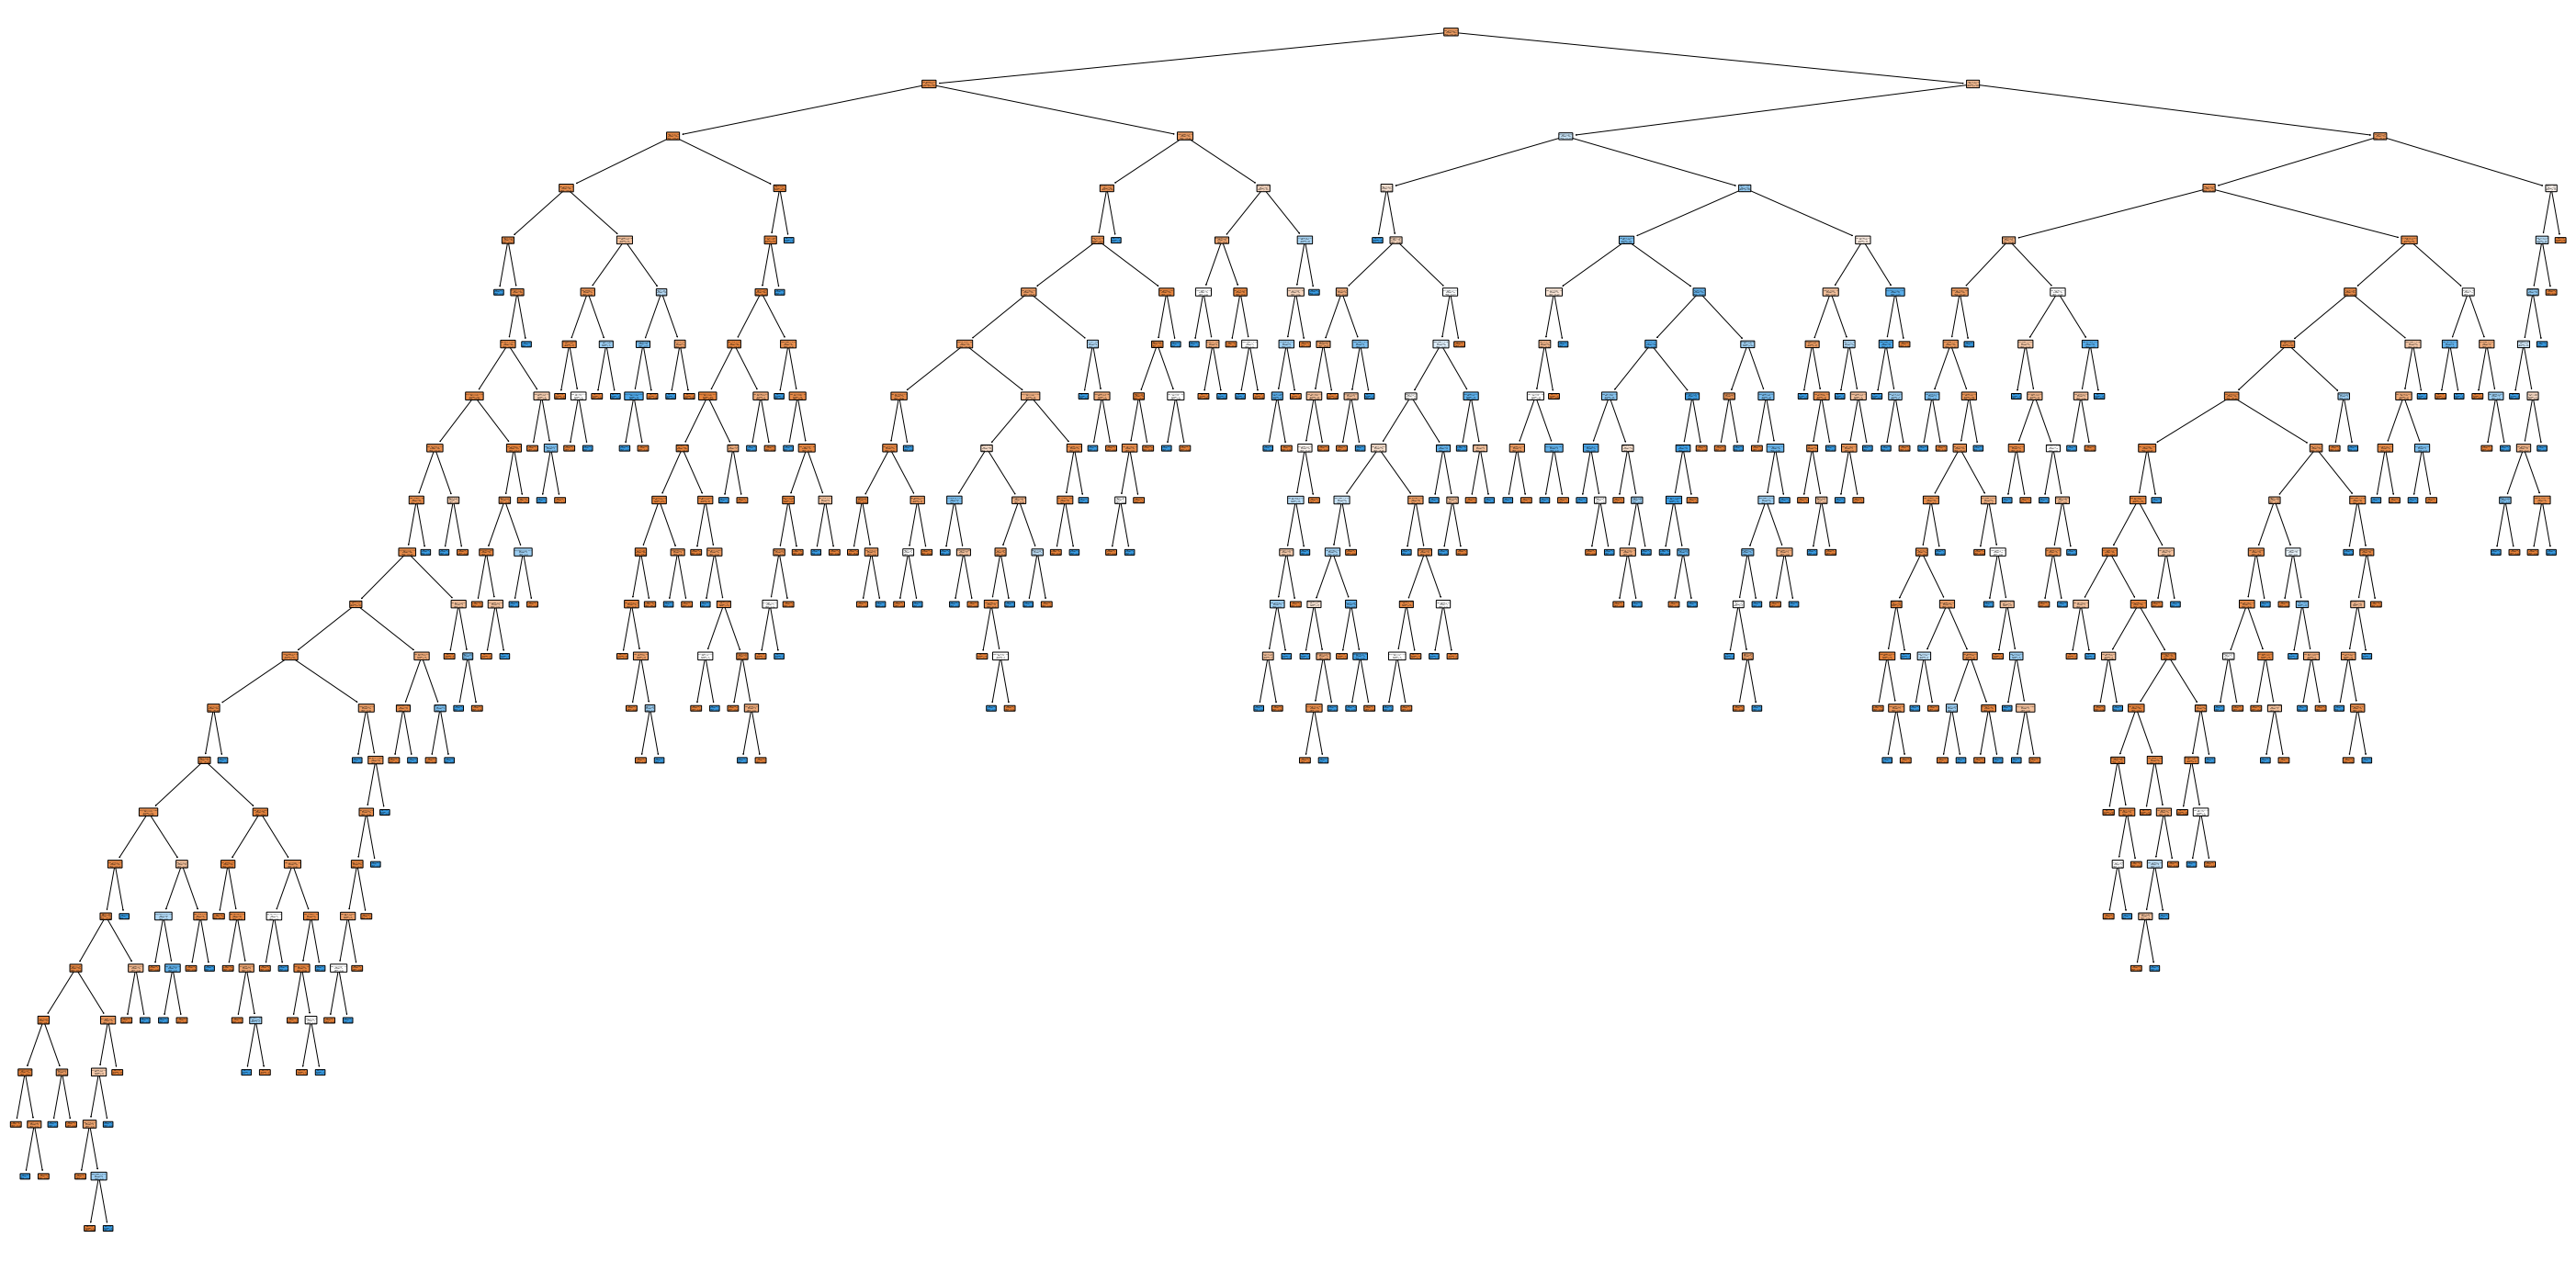

In [405]:
plt.subplots(figsize=(50, 25))

def build_tree(x_vals, targets, features, class_names):
    """
    Build a decision tree based on x, y, feature_names, and class_names.
    """
    train_features, test_features, train_targets, test_targets = train_test_split(x_vals, targets, test_size=0.2, random_state=123)
    decision_tree = tree.DecisionTreeClassifier(random_state=456)
    decision_tree = decision_tree.fit(train_features, train_targets)
    
    tree.plot_tree(decision_tree, feature_names = features, filled=True, rounded=True, class_names = class_names)
    
    print(check_accuracy_decision(decision_tree, train_features, train_targets, test_features, test_targets))
    
    return decision_tree
 
decision_tree = build_tree(x_vals, targets, ling_features_names, class_names)


In [406]:
# Feature Importance as a Data Frame (Decision)

decision_importances_df = feature_importance(ling_features_names, decision_tree)
decision_importances_df

,sent_length,token_length,first_p,second_p,third_p,first_second_p,questions,exclamations,semicolons,commas,...,num_vos,num_future,opinion_count,news_count,num_negation,negation_suffix,num_citations,avg_citation_len,num_words,sentiment
1,0.048759,0.086702,0.015162,0.011272,0.023008,0.022737,0.02798,0.007404,0.028538,0.015028,...,0.166178,0.021436,0.0,0.0,0.033808,0.019855,0.014916,0.025244,0.03479,0.093524


In [407]:
# Feature Importance sorted by Importance (Greatest to least)

decision_importances_tbl = pd.Series(decision_tree.feature_importances_, index = ling_features_names).sort_values(ascending = False)
decision_importances_tbl

num_vos             0.166178
num_causal          0.105301
sentiment           0.093524
token_length        0.086702
periods             0.052141
sent_length         0.048759
digits              0.046184
num_words           0.034790
num_modals          0.034555
num_negation        0.033808
num_temporal        0.028871
semicolons          0.028538
questions           0.027980
avg_citation_len    0.025244
num_contrastive     0.023753
third_p             0.023008
first_second_p      0.022737
num_future          0.021436
negation_suffix     0.019855
first_p             0.015162
commas              0.015028
num_citations       0.014916
num_expansive       0.012856
second_p            0.011272
exclamations        0.007404
opinion_count       0.000000
news_count          0.000000
dtype: float64

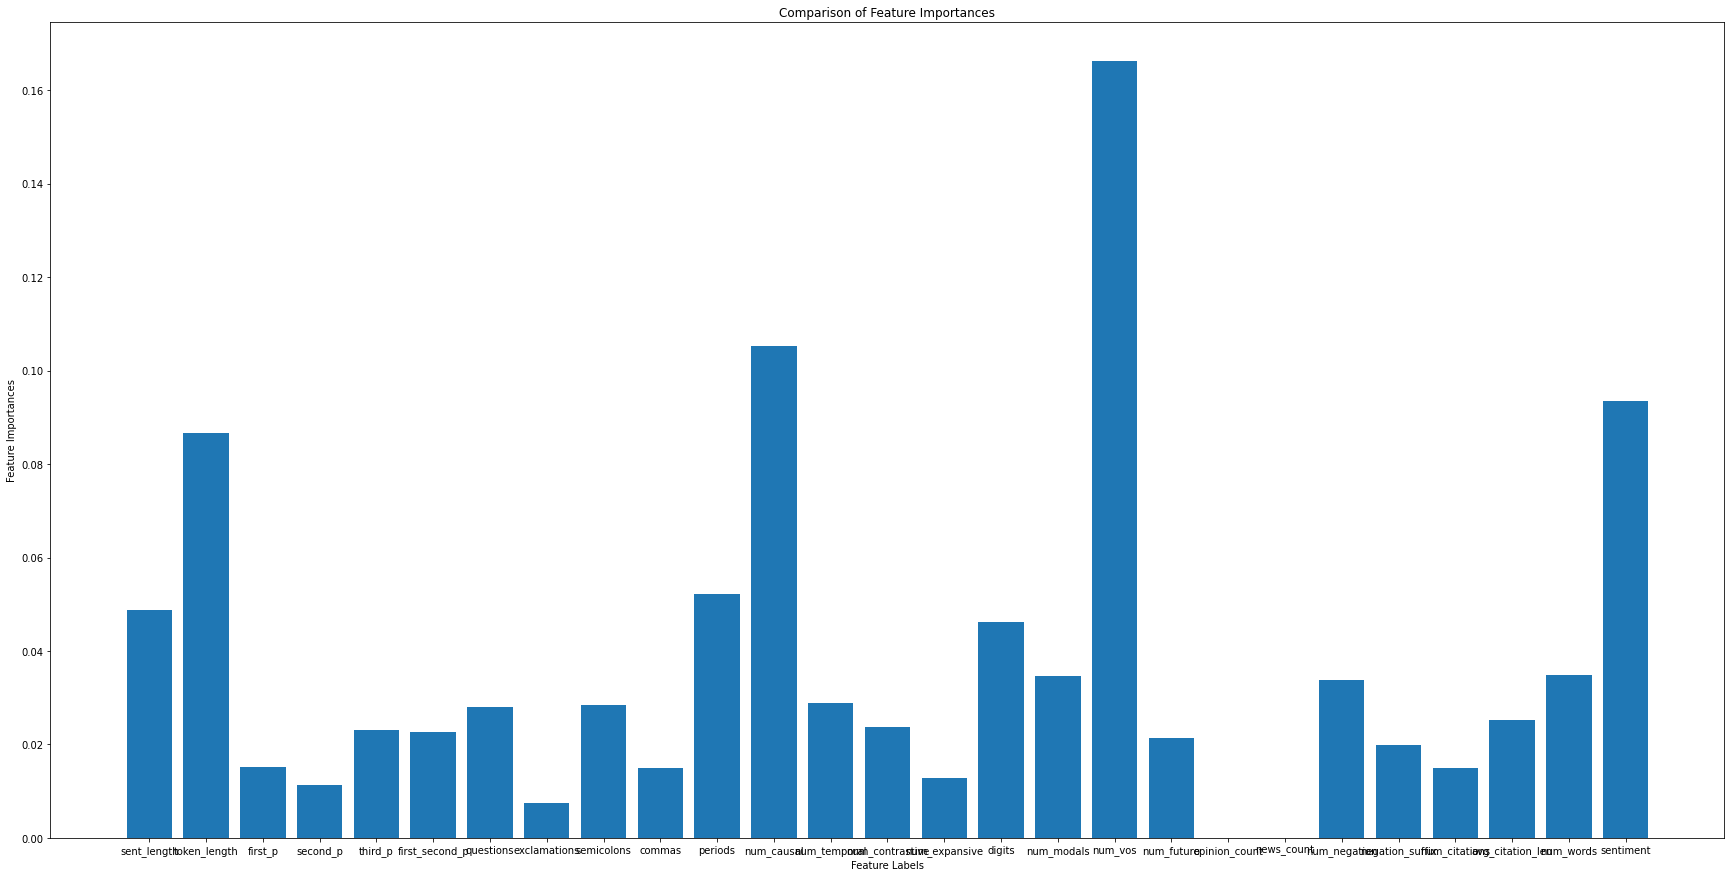

In [408]:
# Bar Chart of Feature Importance (Decision)
plt.rcParams["figure.figsize"] = (30,15)
plt.bar(X.columns, decision_importances_df.to_numpy()[0])
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of Feature Importances')
plt.show()

In [409]:
def tree_as_text(decision_tree, feature_names):
    """
    Prints Tree as Text.
    """
    print(feature_names)
    tree_as_text = tree.export_text(decision_tree, feature_names=feature_names)
    print(tree_as_text)
    
tree_as_text(decision_tree, ling_features_names)

['sent_length', 'token_length', 'first_p', 'second_p', 'third_p', 'first_second_p', 'questions', 'exclamations', 'semicolons', 'commas', 'periods', 'num_causal', 'num_temporal', 'num_contrastive', 'num_expansive', 'digits', 'num_modals', 'num_vos', 'num_future', 'opinion_count', 'news_count', 'num_negation', 'negation_suffix', 'num_citations', 'avg_citation_len', 'num_words', 'sentiment']
|--- num_causal <= 39.50
|   |--- num_modals <= 5.50
|   |   |--- num_vos <= 3.50
|   |   |   |--- num_causal <= 32.50
|   |   |   |   |--- periods <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- periods >  0.50
|   |   |   |   |   |--- sentiment <= 0.12
|   |   |   |   |   |   |--- num_words <= 657.50
|   |   |   |   |   |   |   |--- avg_citation_len <= 52.25
|   |   |   |   |   |   |   |   |--- num_expansive <= 1.50
|   |   |   |   |   |   |   |   |   |--- num_citations <= 9.50
|   |   |   |   |   |   |   |   |   |   |--- avg_citation_len <= 44.50
|   |   |   |   |   |   |   |   |   |

# Extra Trees


In [410]:
from sklearn.ensemble import ExtraTreesClassifier

# Build the Tree Model

extra_tree_forest = ExtraTreesClassifier(n_estimators = 100, criterion = 'entropy',  max_features = 26)

In [411]:
# Training

train_features, test_features, train_targets, test_targets = train_test_split(x_vals, y_vals, test_size=0.3, random_state=123)

extra_tree_forest.fit(train_features, train_targets)

ExtraTreesClassifier(criterion='entropy', max_features=26)

In [412]:
# Feature Importance as a Data Frame (Extra Trees)

feature_importance_extras = feature_importance(ling_features_names, extra_tree_forest)
feature_importance_extras

,sent_length,token_length,first_p,second_p,third_p,first_second_p,questions,exclamations,semicolons,commas,...,num_vos,num_future,opinion_count,news_count,num_negation,negation_suffix,num_citations,avg_citation_len,num_words,sentiment
1,0.030492,0.034468,0.056911,0.023139,0.035552,0.042698,0.046911,0.01406,0.033378,0.026224,...,0.114354,0.028517,0.0,0.0,0.038172,0.041555,0.02952,0.040589,0.042428,0.045662


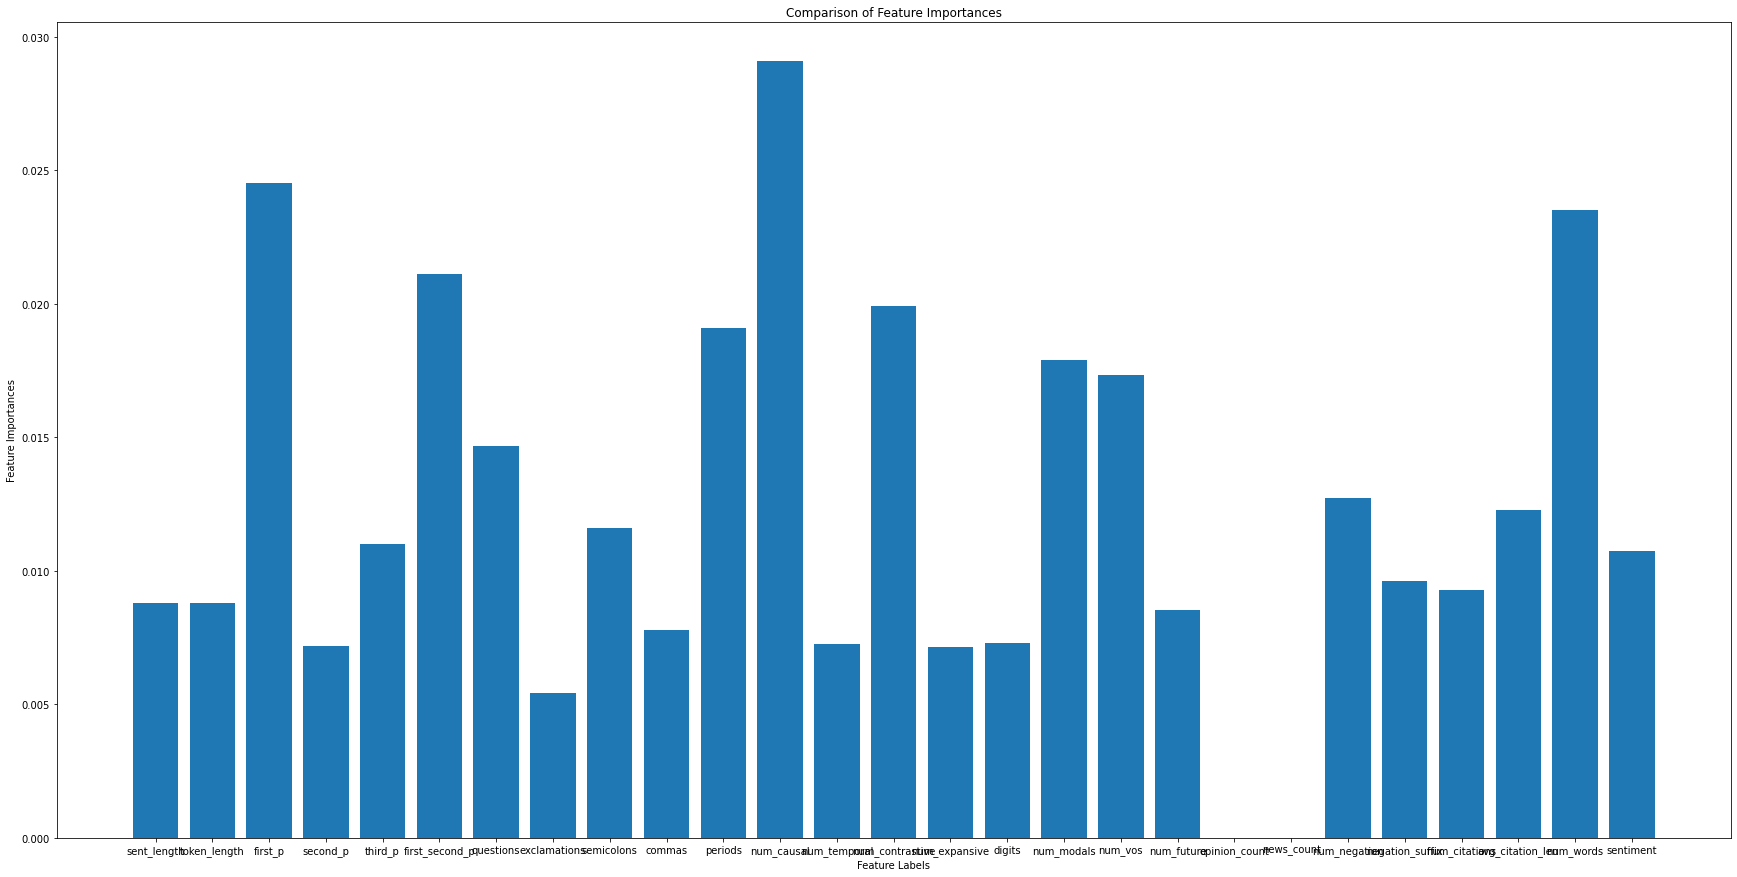

In [413]:
# Feature Importance as a Bar Chart
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

plt.rcParams["figure.figsize"] = (30,15)
plt.bar(X.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of Feature Importances')
plt.show()

In [414]:
# Feature Importance in Sorted Order (Greatest to Least)
pd.Series(extra_tree_forest.feature_importances_, index = ling_features_names).sort_values(ascending = False)

num_vos             0.114354
num_causal          0.064276
first_p             0.056911
questions           0.046911
num_modals          0.046342
sentiment           0.045662
first_second_p      0.042698
num_words           0.042428
num_contrastive     0.042409
negation_suffix     0.041555
avg_citation_len    0.040589
num_negation        0.038172
periods             0.036774
third_p             0.035552
token_length        0.034468
semicolons          0.033378
num_expansive       0.031493
sent_length         0.030492
num_citations       0.029520
num_future          0.028517
digits              0.028445
commas              0.026224
num_temporal        0.025631
second_p            0.023139
exclamations        0.014060
news_count          0.000000
opinion_count       0.000000
dtype: float64

In [415]:
def check_accuracy_extra(extra_trees, test_data, test_targets):
    """
    Returns training and testing mean accuracy. 
    """
    return extra_trees.score(test_data, test_targets)

check_accuracy_extra(extra_tree_forest, test_features, test_targets)

0.8713615023474178

# Random Forests

In [416]:
from sklearn.ensemble import RandomForestClassifier
data_features.head()

,sent_length,token_length,first_p,second_p,third_p,first_second_p,questions,exclamations,semicolons,commas,...,num_future,opinion_count,news_count,num_negation,negation_suffix,num_citations,avg_citation_len,num_words,sentiment,Article Status
0,0.014793,0.201974,1.0,2.0,44.0,3.0,0.0,0.0,78.0,3.0,...,6.0,0.0,0.0,8.0,0.0,0.0,0.000000,1514.0,0.039432,News
1,0.007687,0.190626,9.0,3.0,51.0,12.0,1.0,0.0,92.0,3.0,...,2.0,0.0,0.0,10.0,2.0,41.0,65.195122,1456.0,0.068338,News
2,0.021409,0.200954,1.0,0.0,21.0,1.0,0.0,0.0,30.0,1.0,...,3.0,0.0,0.0,2.0,0.0,0.0,0.000000,632.0,0.057120,Opinion
3,0.007177,0.187560,5.0,0.0,20.0,5.0,0.0,0.0,31.0,1.0,...,3.0,0.0,0.0,6.0,2.0,5.0,113.400000,784.0,0.077041,Opinion
4,0.005999,0.187835,1.0,0.0,20.0,1.0,0.0,0.0,50.0,0.0,...,2.0,0.0,0.0,8.0,0.0,0.0,0.000000,945.0,0.058836,News


In [417]:
# Splitting the Data 

x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size = 0.3)

In [418]:
# Set up Random Forest Model
b_estimator = 0
accuracy = 0

"""
for i in range(50, 300, 5):
    random_forest = RandomForestClassifier(n_estimators = i) 
    random_forest.fit(x_train, y_train)
    if (check_accuracy_random(y_test, random_forest.predict(x_test)) > max_total):
        max_total = check_accuracy_random(y_test, random_forest.predict(x_test))
        max_estimators = i
print(max_estimators, max_total)
"""

random_forest = RandomForestClassifier(n_estimators = 225) 
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=225)

In [419]:
# Predictions 

y_pred = random_forest.predict(x_test)

In [420]:
from sklearn import metrics

def check_accuracy_random(y_test, y_pred):
    """
    Returns the accuracy of your model based on testing data and prediction.
    """
    return metrics.accuracy_score(y_test, y_pred)

check_accuracy_random(y_test, y_pred)

0.8741784037558685

In [421]:
# Features Importance as a Data Frame (Random Trees)

feature_importance_random_df = feature_importance(ling_features_names, random_forest)
feature_importance_random_df

,sent_length,token_length,first_p,second_p,third_p,first_second_p,questions,exclamations,semicolons,commas,...,num_vos,num_future,opinion_count,news_count,num_negation,negation_suffix,num_citations,avg_citation_len,num_words,sentiment
1,0.041001,0.046785,0.045164,0.018711,0.043399,0.047078,0.052918,0.007752,0.044471,0.019419,...,0.093622,0.026967,0.0,0.0,0.03183,0.025478,0.029608,0.039759,0.058879,0.071096


In [422]:
# Features Importance in Order (Greatest to Least)

feature_importance_random = pd.Series(random_forest.feature_importances_, index = ling_features_names).sort_values(ascending = False)
feature_importance_random

num_vos             0.093622
sentiment           0.071096
num_causal          0.061989
num_words           0.058879
questions           0.052918
first_second_p      0.047078
token_length        0.046785
periods             0.046201
first_p             0.045164
semicolons          0.044471
third_p             0.043399
sent_length         0.041001
avg_citation_len    0.039759
num_modals          0.038326
num_contrastive     0.034685
digits              0.033500
num_negation        0.031830
num_citations       0.029608
num_future          0.026967
negation_suffix     0.025478
num_temporal        0.024993
commas              0.019419
second_p            0.018711
num_expansive       0.016370
exclamations        0.007752
opinion_count       0.000000
news_count          0.000000
dtype: float64

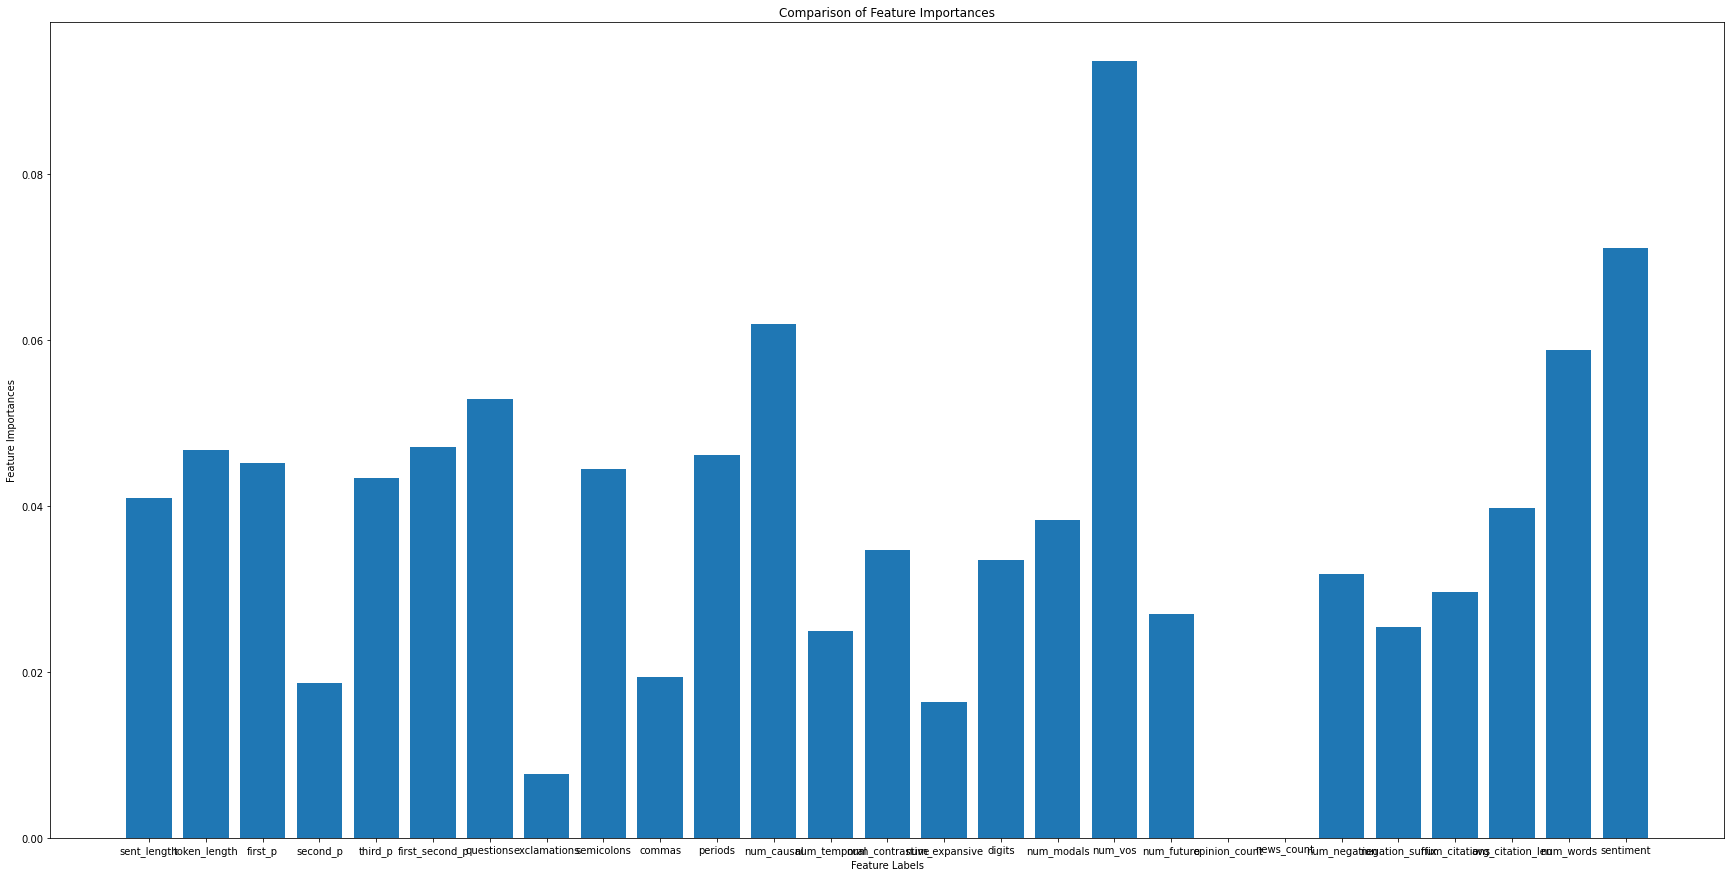

In [423]:
# Bar Chart of Feature Importance 

plt.rcParams["figure.figsize"] = (30,15)
plt.bar(X.columns, feature_importance_random_df.to_numpy()[0])
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of Feature Importances')
plt.show()